In [9]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

# Load and prepare the dataset

In [10]:
batch_size = 16
img_height = 224
img_width = 224

In [11]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

30007
24006
6001


In [12]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [16]:
train_ds = train_ds.batch(batch_size)

# Extract one batch and apply data augmentation and data preprocessing to it

In [17]:
batch_ = next(iter(train_ds))[0]
augmented_batch_ = data_augmentation(batch_)
preprocessed_augmented_batch = preprocess_input(augmented_batch_)

In [25]:
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        plt.subplot(4, 4, n + 1)
        # if the image is a tensor, convert it to a numpy array
        if isinstance(image_batch[n], tf.Tensor):
            plt.imshow(image_batch[n].numpy().astype("uint8"))
        else:
            plt.imshow(image_batch[n].astype("uint8"))
        plt.axis("off")

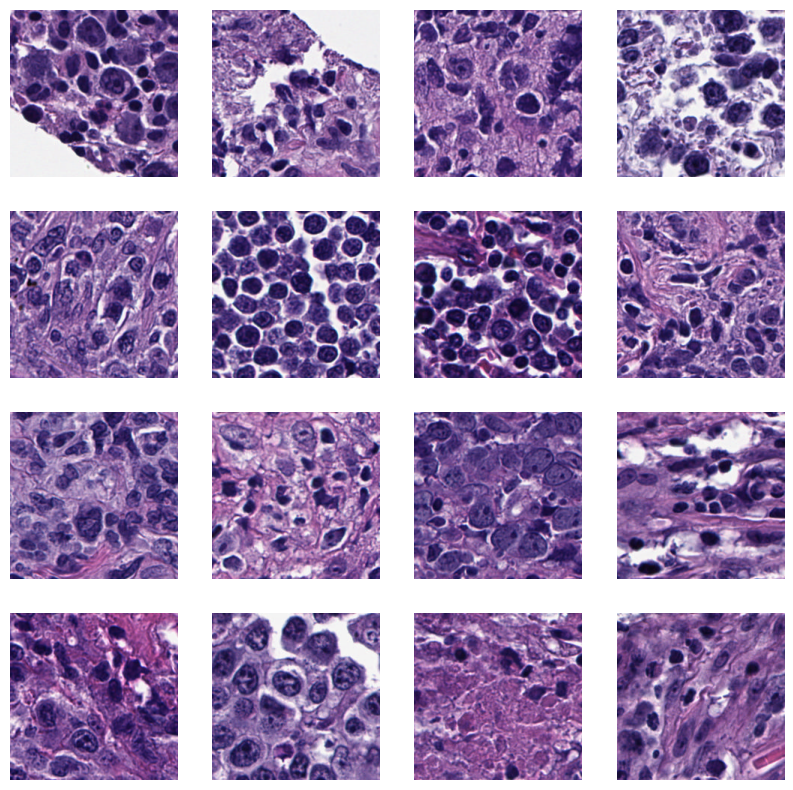

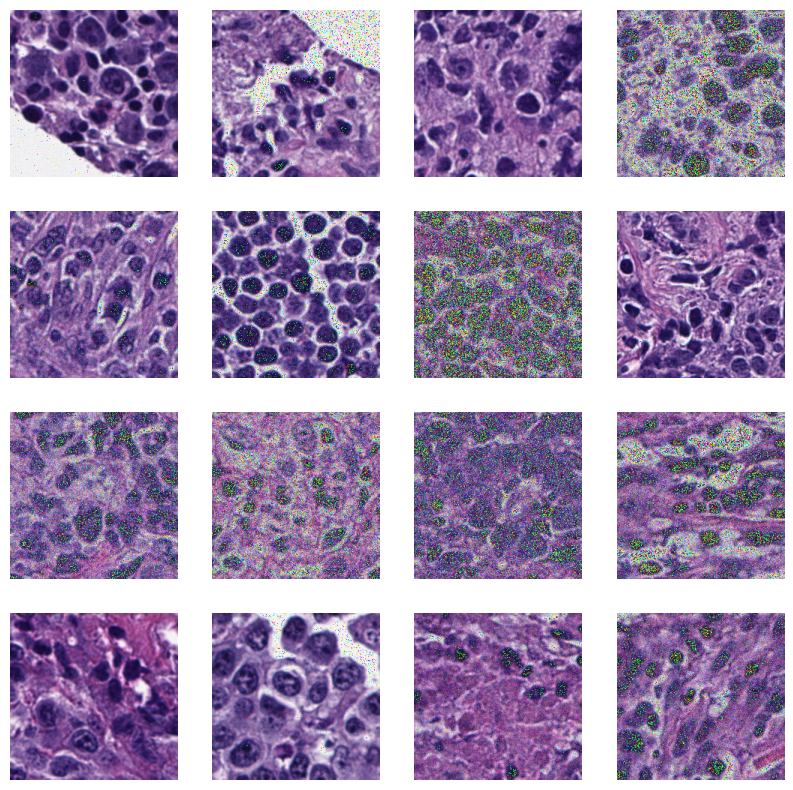

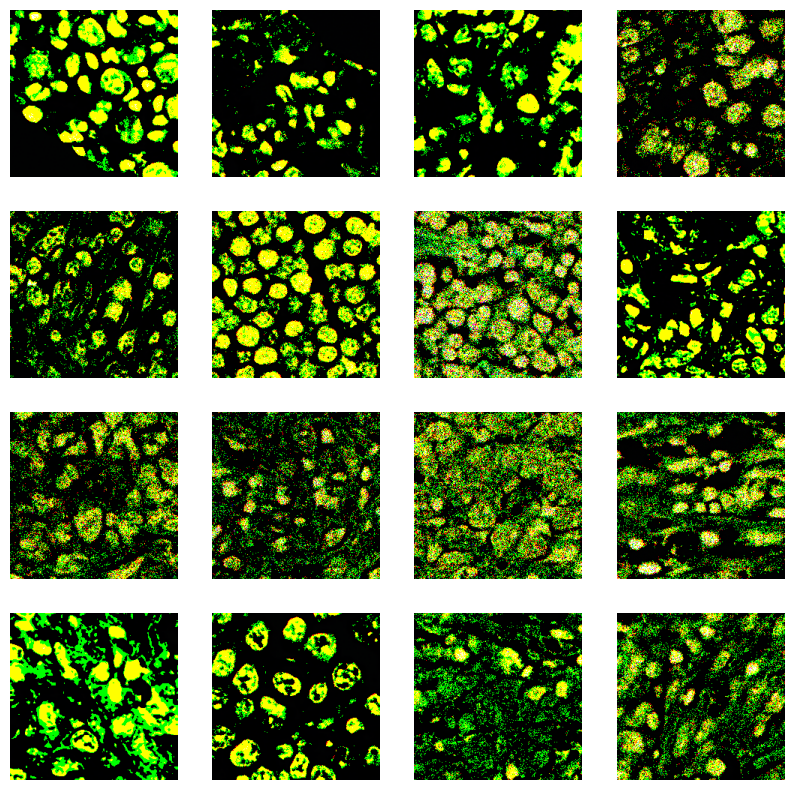

In [26]:
show_batch(batch_)
show_batch(augmented_batch_)
show_batch(preprocessed_augmented_batch)

# Load the model and show the output for the corresponding batch

In [22]:
model = tf.keras.models.load_model("../Models/2.12")

In [23]:
output_batch = model.predict(preprocessed_augmented_batch)

1/1 [==============================] - 4s 4s/step


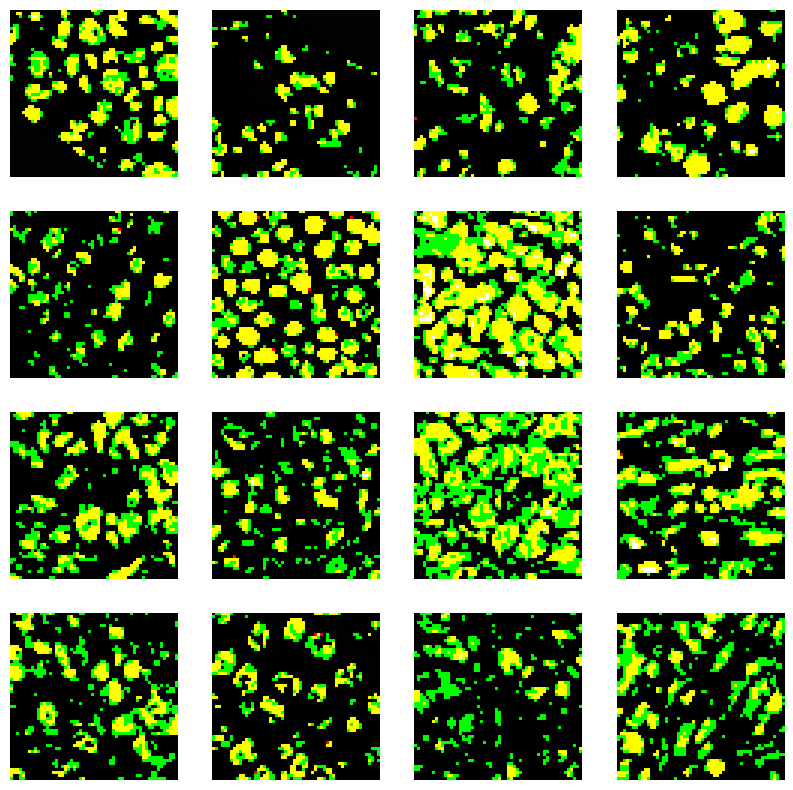

In [27]:
show_batch(output_batch)

In [28]:
# rescale the output to the range [0, 255]
output_batch = (output_batch - output_batch.min()) / (output_batch.max() - output_batch.min())
output_batch = output_batch * 255

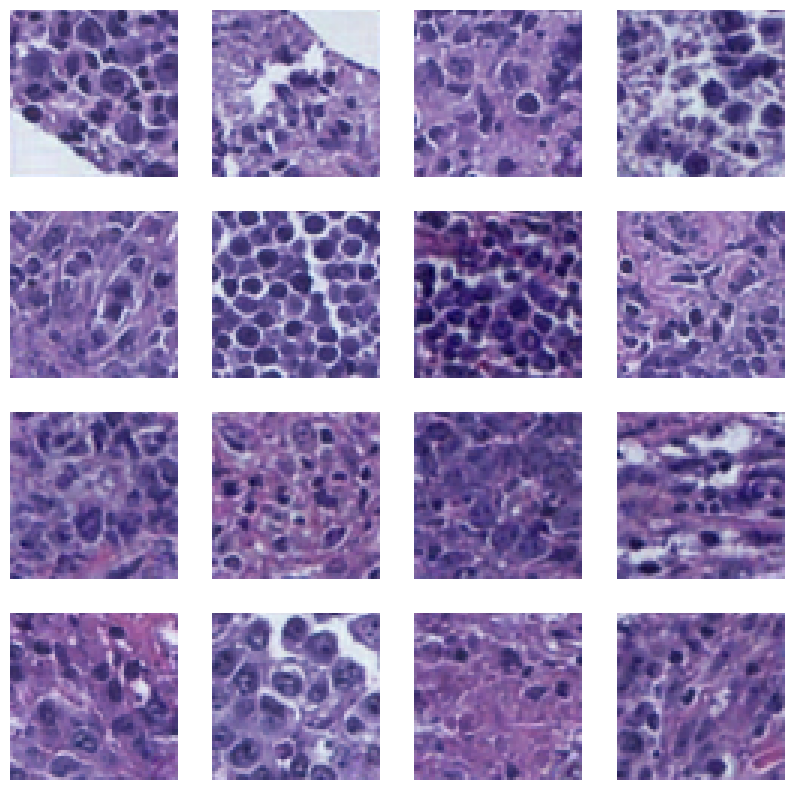

In [29]:
show_batch(output_batch)

# Show the extracted features from the output layer of the encoder part

In [33]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
ae_feature_extractor = Model(inputs=model.layers[-2].inputs, outputs=GlobalAveragePooling2D()(model.layers[-2].outputs[-1]))

In [34]:
batch_features = ae_feature_extractor.predict(preprocessed_augmented_batch)

1/1 [==============================] - 1s 1s/step


In [ ]:
# Convert batch_features into a pandas dataframe
